
# 📘 Notebook 4 — Unsupervised Clustering & Content-Based Recommender

This notebook is the **4th step** of the Book Recommendation Project.

We:
1. Load the cleaned dataset: `books_merged_cleaned.csv`.
2. Apply **Unsupervised Clustering** to group books by characteristics.
3. Build a simple **Content-Based Recommender** using TF-IDF + cosine similarity.
4. Outline how **Collaborative Filtering** and **evaluation** would work.

## 1. Imports & Load Data

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from scipy.sparse import hstack
from sklearn.decomposition import PCA

# Optional: for hierarchical dendrogram
try:
    from scipy.cluster.hierarchy import dendrogram, linkage
    SCIPY_AVAILABLE = True
except:
    SCIPY_AVAILABLE = False

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

df = pd.read_csv("../data/books_merged_cleaned.csv")
print("Shape:", df.shape)
df.head(5)


Shape: (1010, 17)


,title,author,author_url,avg_rating,num_ratings,genres,year,score,book_url,source,title_clean,author_clean,genres_list,genres_clean,rating_0_5,text_for_keywords,top_keywords
0,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,https://www.goodreads.com/author/show/153394.S...,4.35,9748182,"['young adult', 'dystopia', 'fiction', 'fantas...",2008.0,4283248,https://www.goodreads.com/book/show/2767052-th...,goodreads,the hunger games (the hunger games 1),suzanne collins,"['young adult', 'dystopia', 'fiction', 'fantas...","young adult, dystopia, fiction, fantasy, scien...",4.35,the hunger games (the hunger games 1) ['young ...,"adventure, science, fiction, romance, young"
1,Pride and Prejudice,Jane Austen,https://www.goodreads.com/author/show/1265.Jan...,4.29,4722539,"['classics', 'romance', 'fiction', 'historical...",1813.0,2945744,https://www.goodreads.com/book/show/1885.Pride...,goodreads,pride and prejudice,jane austen,"['classics', 'romance', 'fiction', 'historical...","classics, romance, fiction, historical fiction...",4.29,"pride and prejudice ['classics', 'romance', 'f...","historical, audiobook, fiction, romance, liter..."
2,To Kill a Mockingbird,Harper Lee,https://www.goodreads.com/author/show/1825.Har...,4.26,6784603,"['classics', 'fiction', 'historical fiction', ...",1960.0,2589212,https://www.goodreads.com/book/show/2657.To_Ki...,goodreads,to kill a mockingbird,harper lee,"['classics', 'fiction', 'historical fiction', ...","classics, fiction, historical fiction, school,...",4.26,"to kill a mockingbird ['classics', 'fiction', ...","historical, school, fiction, young, literature"
3,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,https://www.goodreads.com/author/show/1077326....,4.50,3745274,"['fantasy', 'young adult', 'fiction', 'harry p...",2003.0,2070361,https://www.goodreads.com/book/show/58613451-h...,goodreads,harry potter and the order of the phoenix (har...,j k rowling,"['fantasy', 'young adult', 'fiction', 'harry p...","fantasy, young adult, fiction, harry potter, m...",4.50,harry potter and the order of the phoenix (har...,"childrens, audiobook, young, adult, fantasy"
4,The Book Thief,Markus Zusak,https://www.goodreads.com/author/show/11466.Ma...,4.39,2840351,"['historical fiction', 'fiction', 'young adult...",2005.0,1958034,https://www.goodreads.com/book/show/19063.The_...,goodreads,the book thief,markus zusak,"['historical fiction', 'fiction', 'young adult...","historical fiction, fiction, young adult, clas...",4.39,"the book thief ['historical fiction', 'fiction...","book, historical, club, fiction, young"


In [26]:
# Quick look at columns
df.columns

Index(['title', 'author', 'author_url', 'avg_rating', 'num_ratings', 'genres',
       'year', 'score', 'book_url', 'source', 'title_clean', 'author_clean',
       'genres_list', 'genres_clean', 'rating_0_5', 'text_for_keywords',
       'top_keywords'],
      dtype='object')


## 2. Clustering Setup — "Book Segmentation"

We treat **books as products** and group them based on:
- Rating (0–5)
- Popularity (number of ratings)
- Genres

Similar books → same cluster.
This is analogous to:
- Customer segmentation
- Product segmentation
- Grouping according to characteristics


### 2.1 Prepare features

In [27]:
# Ensure rating and num_ratings exist
if "rating_0_5" not in df.columns:
    df["rating_0_5"] = pd.to_numeric(df.get("avg_rating", np.nan), errors="coerce").clip(0, 5)

df["num_ratings"] = pd.to_numeric(df.get("num_ratings", 0), errors="coerce").fillna(0)
df["log_num_ratings"] = np.log1p(df["num_ratings"])

# Ensure genres_list exists; if not, create a simple version from 'genres'
if "genres_list" not in df.columns:
    df["genres"] = df["genres"].fillna("").astype(str)
    temp_genres_list = []
    for g in df["genres"]:
        if g.strip() == "":
            temp_genres_list.append([])
        else:
            parts = [x.strip().lower() for x in g.split(",") if x.strip() != ""]
            temp_genres_list.append(parts)
    df["genres_list"] = temp_genres_list

df[["title_clean", "author_clean", "rating_0_5", "log_num_ratings", "genres_list", "text_for_keywords", "top_keywords"]].head(5)

,title_clean,author_clean,rating_0_5,log_num_ratings,genres_list,text_for_keywords,top_keywords
0,the hunger games (the hunger games 1),suzanne collins,4.35,16.092591,"['young adult', 'dystopia', 'fiction', 'fantas...",the hunger games (the hunger games 1) ['young ...,"adventure, science, fiction, romance, young"
1,pride and prejudice,jane austen,4.29,15.367857,"['classics', 'romance', 'fiction', 'historical...","pride and prejudice ['classics', 'romance', 'f...","historical, audiobook, fiction, romance, liter..."
2,to kill a mockingbird,harper lee,4.26,15.730166,"['classics', 'fiction', 'historical fiction', ...","to kill a mockingbird ['classics', 'fiction', ...","historical, school, fiction, young, literature"
3,harry potter and the order of the phoenix (har...,j k rowling,4.50,15.136006,"['fantasy', 'young adult', 'fiction', 'harry p...",harry potter and the order of the phoenix (har...,"childrens, audiobook, young, adult, fantasy"
4,the book thief,markus zusak,4.39,14.859439,"['historical fiction', 'fiction', 'young adult...","the book thief ['historical fiction', 'fiction...","book, historical, club, fiction, young"


### 2.2 One-hot encode top genres

In [28]:
fixed_genres_list = []
for val in df["genres_clean"]:
    if isinstance(val, list):
        fixed_genres_list.append(val)
    elif isinstance(val, str):
        # fallback: split by comma and clean
        parts = [p.strip() for p in val.split(",") if p.strip() != ""]
        fixed_genres_list.append(parts)
    else:
        fixed_genres_list.append([])

df["genres_list"] = fixed_genres_list

# Quick sanity check
print("Example genres_list rows:")
for i in range(5):
    print(df["genres_list"].iloc[i])

Example genres_list rows:
['young adult', 'dystopia', 'fiction', 'fantasy', 'science fiction', 'romance', 'adventure']
['classics', 'romance', 'fiction', 'historical fiction', 'historical', 'literature', 'audiobook']
['classics', 'fiction', 'historical fiction', 'school', 'literature', 'young adult', 'historical']
['fantasy', 'young adult', 'fiction', 'harry potter', 'magic', 'audiobook', 'childrens']
['historical fiction', 'fiction', 'young adult', 'classics', 'historical', 'book club']


In [29]:
# Count how often each genre appears
genre_counter = Counter()

for glist in df["genres_list"]:
    if isinstance(glist, list):
        for g in glist:
            if isinstance(g, str):
                g_clean = g.strip()
                # ignore empty / tiny tokens, just in case
                if g_clean != "" and len(g_clean) > 2:
                    genre_counter[g_clean] += 1

# Select top N genres to keep things simple
top_n = 20
top_genres = [g for g, c in genre_counter.most_common(top_n)]
print("Top genres:", top_genres)

# Create dummy columns for these top genres
for g in top_genres:
    col = "genre_" + g.replace(" ", "_")
    df[col] = df["genres_list"].apply(
        lambda lst: 1 if isinstance(lst, list) and g in lst else 0
    )

# Quick preview of genre feature columns
genre_cols = [c for c in df.columns if c.startswith("genre_")]
df[["title"] + genre_cols].head(5)

Top genres: ['fiction', 'classics', 'fantasy', 'romance', 'young adult', 'historical fiction', 'general', 'literature', 'audiobook', 'mystery', 'historical', 'contemporary', 'book club', 'science fiction', 'adventure', 'novels', 'thriller', 'history', 'childrens', 'horror']


,title,genre_fiction,genre_classics,genre_fantasy,genre_romance,genre_young_adult,genre_historical_fiction,genre_general,genre_literature,genre_audiobook,genre_mystery,genre_historical,genre_contemporary,genre_book_club,genre_science_fiction,genre_adventure,genre_novels,genre_thriller,genre_history,genre_childrens,genre_horror
0,"The Hunger Games (The Hunger Games, #1)",1,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,Pride and Prejudice,1,1,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0
2,To Kill a Mockingbird,1,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,Harry Potter and the Order of the Phoenix (Har...,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,The Book Thief,1,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0


In [30]:
feature_cols = ["rating_0_5", "log_num_ratings"] + [c for c in df.columns if c.startswith("genre_")]
X = df[feature_cols].fillna(0)

print("Feature matrix shape:", X.shape)
X.tail(5)

Feature matrix shape: (1010, 22)


,rating_0_5,log_num_ratings,genre_fiction,genre_classics,genre_fantasy,genre_romance,genre_young_adult,genre_historical_fiction,genre_general,genre_literature,genre_audiobook,genre_mystery,genre_historical,genre_contemporary,genre_book_club,genre_science_fiction,genre_adventure,genre_novels,genre_thriller,genre_history,genre_childrens,genre_horror
1005,4.11,3.583519,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1006,1.00,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1007,3.67,1.386294,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1008,4.50,1.098612,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1009,3.83,3.218876,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2.3 Scale features

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:3]

array([[ 0.60673292,  1.37851183,  0.5613414 , -0.67012494,  1.65551827,
         1.92863324,  2.01246118, -0.44028789, -0.42415391, -0.41435943,
        -0.38435306, -0.37582301, -0.35845728, -0.35669615, -0.35493024,
         3.03348318,  3.10347852, -0.30894123, -0.30313675, -0.2992259 ,
        -0.28322059, -0.27912044],
       [ 0.47625735,  1.2485941 ,  0.5613414 ,  1.49225905, -0.60404045,
         1.92863324, -0.49690399,  2.2712412 , -0.42415391,  2.41336369,
         2.60177454, -0.37582301,  2.78973273, -0.35669615, -0.35493024,
        -0.32965404, -0.32221908, -0.30894123, -0.30313675, -0.2992259 ,
        -0.28322059, -0.27912044],
       [ 0.41101957,  1.31354258,  0.5613414 ,  1.49225905, -0.60404045,
        -0.5185019 ,  2.01246118,  2.2712412 , -0.42415391,  2.41336369,
        -0.38435306, -0.37582301,  2.78973273, -0.35669615, -0.35493024,
        -0.32965404, -0.32221908, -0.30894123, -0.30313675, -0.2992259 ,
        -0.28322059, -0.27912044]])


## 3. K-Means Clustering — Grouping Books

We use **K-Means**:
- Choose k clusters.
- Each book is assigned to the nearest centroid.
- The centroid is the "prototype" of that cluster.


### 3.1 Choose k (quick elbow-style check)

In [32]:
# k_values = [3, 4, 5, 6, 7]
k_values = range(3, 9)
inertias = []

for k in k_values:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_tmp.fit(X_scaled)
    inertias.append(kmeans_tmp.inertia_)

for k, inertia in zip(k_values, inertias):
    print("k =", k, "-> inertia:", round(inertia, 2))

k = 3 -> inertia: 17420.98
k = 4 -> inertia: 15686.79
k = 5 -> inertia: 14677.88
k = 6 -> inertia: 13710.35
k = 7 -> inertia: 12888.65
k = 8 -> inertia: 11987.54


In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(k_values), y=inertias, mode='lines+markers', name='Inertia'))
fig.update_layout(title='Elbow Method For Optimal k',
                  xaxis_title='Number of clusters, k',
                  yaxis_title='Inertia',
                  xaxis=dict(tickmode='array', tickvals=list(k_values)))

fig.write_html("../figures/elbow_method_for_optimal_k.html", include_plotlyjs="cdn")
fig.show()

In [34]:
# For simplicity, we pick k = 4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X_scaled)

df["cluster_kmeans"] = kmeans.labels_
df["cluster_kmeans"].value_counts().sort_index()

cluster_kmeans
0     98
1    458
2    255
3    199
Name: count, dtype: int64

### 3.2 Cluster profiles

In [35]:
cluster_profile = df.groupby("cluster_kmeans")[["rating_0_5", "num_ratings"]].mean().round(2)
cluster_profile

,rating_0_5,num_ratings
cluster_kmeans,,
0,4.06,792918.28
1,4.03,44779.32
2,4.17,1152424.82
3,4.05,767386.69


### 3.3 Prototype books (closest to centroids)

In [36]:
distances = kmeans.transform(X_scaled)

prototype_indices = []

for cluster_id in range(k):
    mask = df["cluster_kmeans"] == cluster_id
    cluster_distances = distances[mask, cluster_id]
    if cluster_distances.size > 0:
        local_idx = cluster_distances.argmin()
        global_idx = df[mask].index[local_idx]
        prototype_indices.append(global_idx)

print("Most representative (prototype) book per cluster:")
df.loc[prototype_indices, ["cluster_kmeans", "title", "author", "genres_clean", "rating_0_5", "num_ratings"]]


Most representative (prototype) book per cluster:


,cluster_kmeans,title,author,genres_clean,rating_0_5,num_ratings
440,0,The Firm,John Grisham,"fiction, thriller, mystery, crime, suspense, m...",4.06,637337
915,1,El misterio del ojo esmeralda (Lost Treasure o...,Elisabetta Dami,"children s fiction, stilton, geronimo fictitio...",4.00,19
344,2,"City of Lost Souls (The Mortal Instruments, #5)",Cassandra Clare,"fantasy, young adult, romance, paranormal, urb...",4.21,563435
410,3,The Hunchback of Notre-Dame,Victor Hugo,"classics, fiction, historical fiction, france,...",4.02,215998



## 4. Hierarchical Clustering (small sample)

Example of grouping by similarity using a tree structure.
We show a dendrogram only on a small sample to keep it light.


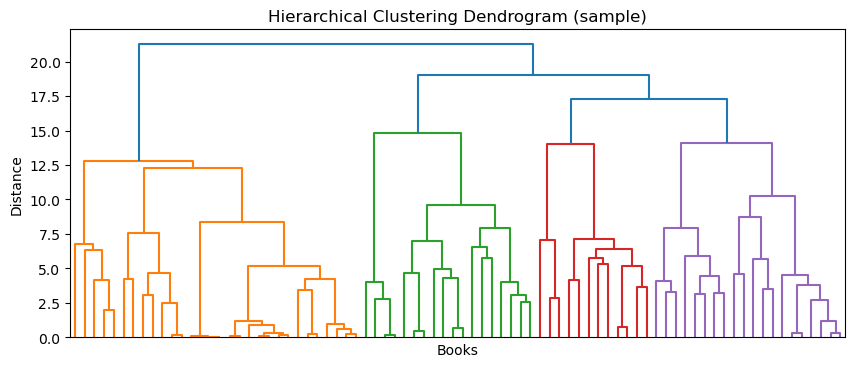

In [37]:
if SCIPY_AVAILABLE:
    sample_n = min(80, len(df))
    df_sample = df.sample(sample_n, random_state=42)

    X_sample = df_sample[feature_cols].fillna(0)
    X_sample_scaled = scaler.fit_transform(X_sample)

    Z = linkage(X_sample_scaled, method="ward")

    plt.figure(figsize=(10, 4))
    dendrogram(Z, no_labels=True, count_sort=True)
    plt.title("Hierarchical Clustering Dendrogram (sample)")
    plt.xlabel("Books")
    plt.ylabel("Distance")
    plt.savefig("../figures/hierarchical_clustering_dendrogram.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Cut into 4 clusters as an example
    agg = AgglomerativeClustering(n_clusters=4)
    labels_agg = agg.fit_predict(X_sample_scaled)
    df_sample["cluster_hier"] = labels_agg
    df_sample[["title", "cluster_hier"]].head(10)
else:
    print("scipy not installed; skipping hierarchical example.")


> Other clustering models (DBSCAN, HDBSCAN, GMM) can also be explored.
> For this project level, K-Means + a small hierarchical example is enough.



## 5. Content-Based Recommendation

Now we build a simple **Content-Based Filtering** model:

- Represent each book using text (title + genres).
- Use **TF-IDF** to convert text into vectors.
- Use **cosine similarity** to find similar books.


### 5.1 Prepare text field

In [38]:
# If 'text_for_keywords' exists from previous notebook, reuse it.
# Otherwise, create it from title + genres.
if "text_for_keywords" not in df.columns:
    if "genres_clean" in df.columns:
        base_genres = df["genres_clean"]
    else:
        base_genres = df.get("genres", "").fillna("").astype(str)
    df["text_for_keywords"] = df["title"].fillna("").astype(str) + " " + base_genres

df["text_for_keywords"] = df["text_for_keywords"].fillna("").astype(str).str.lower()
df["text_for_keywords"].head(5)

0    the hunger games (the hunger games 1) ['young ...
1    pride and prejudice ['classics', 'romance', 'f...
2    to kill a mockingbird ['classics', 'fiction', ...
3    harry potter and the order of the phoenix (har...
4    the book thief ['historical fiction', 'fiction...
Name: text_for_keywords, dtype: object

### 5.2 TF-IDF vectors

In [39]:
max_features = 50

vectorizer = TfidfVectorizer(
    max_features=max_features,
    stop_words="english"
)

tfidf_matrix = vectorizer.fit_transform(df["text_for_keywords"])
feature_names = vectorizer.get_feature_names_out()

print("TF-IDF shape:", tfidf_matrix.shape)
print("Some features:", feature_names[:100])

TF-IDF shape: (1010, 50)
Some features: ['adult' 'adventure' 'american' 'audiobook' 'bestseller' 'book' 'books'
 'character' 'children' 'childrens' 'classics' 'club' 'contemporary'
 'detective' 'english' 'fantasy' 'fiction' 'fictitious' 'general' 'grade'
 'historical' 'history' 'horror' 'juvenile' 'language' 'large' 'life'
 'literary' 'literature' 'middle' 'mystery' 'new' 'nonfiction' 'novels'
 'paranormal' 'philosophy' 'psychology' 'romance' 'school' 'science'
 'social' 'stories' 'suspense' 'thriller' 'times' 'type' 'women' 'works'
 'york' 'young']


In [40]:
# ============================
# COMBINE GENRE + TEXT FEATURES
# ============================

# Select the genre columns we created
genre_cols = [c for c in df.columns if c.startswith("genre_")]

# Convert genres to numeric matrix
X_genres = df[genre_cols].values

# Combine (hstack) genres + tfidf into a single feature matrix
# X will be used to measure similarity between books
X = hstack([X_genres, tfidf_matrix])

print("Final feature matrix shape:", X.shape)

Final feature matrix shape: (1010, 70)


Reduce to 2D with PCA

In [41]:
display(df[["title", "author", "cluster_kmeans"]].head(10))

# PCA works on dense arrays, so we convert X to dense for a small sample.
# If the full matrix is large, we can sample a subset.
# For the bootcamp dataset size, this is usually fine.

X_dense = X.toarray()

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_dense)

print("PCA 2D shape:", X_2d.shape)

# Store coordinates in the dataframe (optional, for inspection)
df["pc1"] = X_2d[:, 0]
df["pc2"] = X_2d[:, 1]

,title,author,cluster_kmeans
0,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,2
1,Pride and Prejudice,Jane Austen,3
2,To Kill a Mockingbird,Harper Lee,3
3,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,2
4,The Book Thief,Markus Zusak,3
5,"Twilight (The Twilight Saga, #1)",Stephenie Meyer,2
6,Animal Farm,George Orwell,3
7,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien,2
8,The Chronicles of Narnia (The Chronicles of Na...,C.S. Lewis,2
9,The Fault in Our Stars,John Green,2


PCA 2D shape: (1010, 2)


Scatterplot of clusters

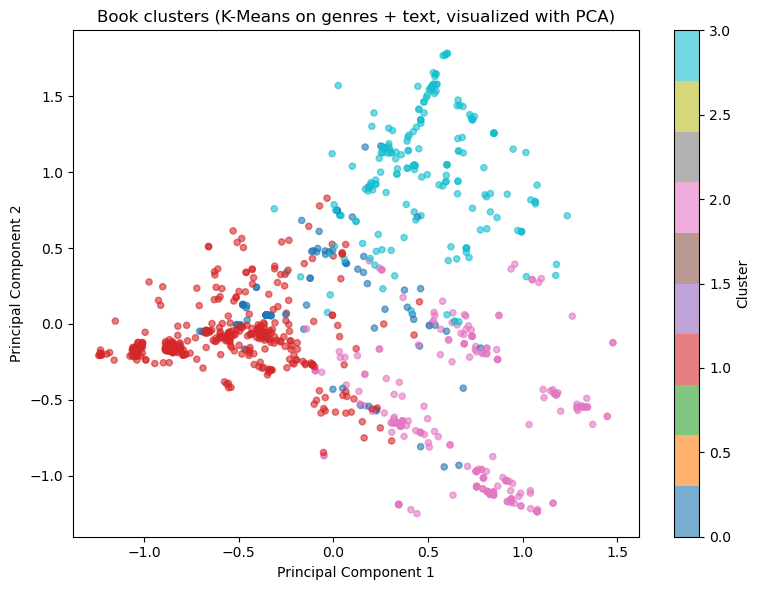

In [42]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    df["pc1"],
    df["pc2"],
    c=df["cluster_kmeans"],
    cmap="tab10",
    alpha=0.6,
    s=20
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Book clusters (K-Means on genres + text, visualized with PCA)")
plt.colorbar(scatter, label="Cluster")
plt.tight_layout()
plt.savefig("../figures/book_clusters_k_means_genres_text_visualized_pca.png", dpi=300, bbox_inches="tight")
plt.show()

### 5.3 Cosine similarity

In [43]:
# ============================
# COSINE SIMILARITY MATRIX
# ============================

# Cosine similarity tells us how similar two vectors are
# 1.0 = very similar, 0 = no similarity

cosine_sim = cosine_similarity(tfidf_matrix)
print("Cosine similarity matrix shape:", cosine_sim.shape)

# Sanity check: similarity of a book with itself (should be 1)
print("Self-similarity of first book:", cosine_sim[0, 0])

Cosine similarity matrix shape: (1010, 1010)
Self-similarity of first book: 1.0000000000000002


### 5.4 Recommend similar books for a chosen title

In [44]:
# Step 1: choose a book title (test with different titles)
query_title = "Cave Bear"
# query_title = "potter"

# Step 2: find matches
matches = df[df["title_clean"].str.contains(query_title, case=False, na=False)]

print("Matches found:")
display(matches[["title", "author", "genres_clean"]].head(10))

Matches found:


,title,author,genres_clean
235,"The Clan of the Cave Bear (Earth's Children, #1)",Jean M. Auel,"historical fiction, fiction, fantasy, historic..."
995,The Clan of the Cave Bear,Jean M. Auel,"neanderthals, shamanism, sign language, taboos..."


In [45]:
# Step 3: if a match exists, use the first one and get recommendations
if len(matches) > 0:
    idx = matches.index[0]
    print("Using index:", idx, "-", df.loc[idx, "title"], "by", df.loc[idx, "author"])

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores_sorted = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    N = 10
    print("\nTop", N, "similar books:")
    count = 0
    for i, score in sim_scores_sorted:
        if i == idx:
            continue
        title_i = df.loc[i, "title"]
        author_i = df.loc[i, "author"]
        genre_i = df.loc[i, "genres_clean"]
        print(f"{count+1}. (similarity={score:.3f}) {title_i} — {author_i} — {genre_i}")
        count += 1
        if count >= N:
            break
else:
    print("No match found. Try another query_title.")

Using index: 235 - The Clan of the Cave Bear (Earth's Children, #1) by Jean M. Auel

Top 10 similar books:
1. (similarity=0.807) The Scarlet Pimpernel — Emmuska Orczy — classics, historical fiction, fiction, romance, adventure, historical, mystery
2. (similarity=0.791) Voyager (Outlander, #3) — Diana Gabaldon — historical fiction, romance, fantasy, fiction, time travel, historical, outlander
3. (similarity=0.786) Cold Mountain — Charles Frazier — historical fiction, fiction, historical, romance, civil war, classics
4. (similarity=0.786) North and South — Elizabeth Gaskell — classics, fiction, romance, historical fiction, historical, th century, victorian
5. (similarity=0.778) The Mists of Avalon (Avalon, #1) — Marion Zimmer Bradley — fantasy, fiction, historical fiction, arthurian, mythology, classics, historical
6. (similarity=0.774) The Count of Monte Cristo — Alexandre Dumas — classics, fiction, historical fiction, adventure, literature, france, historical
7. (similarity=0.774) Outl

### 5.4 Quick Visualization of Similarities

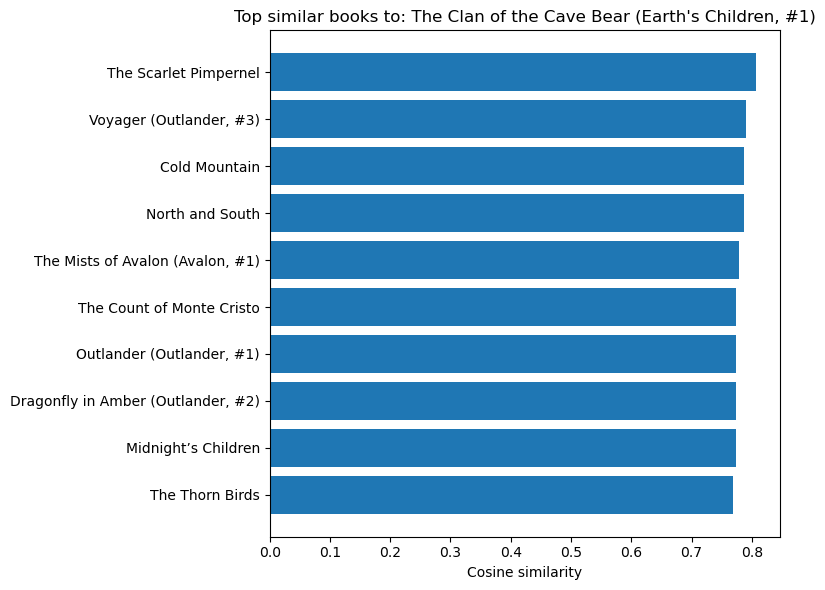

In [46]:
# ============================
# VISUALIZE SIMILARITY SCORES FOR ONE BOOK
# ============================

if len(matches) > 0:
    idx = matches.index[0]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]

    scores = [s for i, s in sim_scores]
    titles = [df.loc[i, "title"] for i, s in sim_scores]

    plt.figure(figsize=(8, 6))
    plt.barh(range(len(scores)), scores)
    plt.yticks(range(len(scores)), titles)
    plt.gca().invert_yaxis()
    plt.xlabel("Cosine similarity")
    plt.title("Top similar books to: " + df.loc[idx, "title"])
    plt.tight_layout()
    plt.show()


## 6. Collaborative Filtering (Conceptual)

**Collaborative Filtering (CF)** uses a **user–book rating matrix**:
- Rows = users
- Columns = books
- Values = ratings.

With such data we could:
- Find similar users (user-based CF).
- Find similar books (item-based CF).
- Use libraries like `surprise`, `implicit`, or plain cosine similarity.

In this project:
- Our dataset is book-level (no per-user ratings).
- So a full CF implementation is **not included** here.
- If you add user-rating data later:
  - Build a user-item matrix.
  - Compute similarities.
  - Evaluate with metrics like RMSE, Precision@k, Recall@k.



## 7. Model Evaluation (Simple)

Without real user interaction data, we cannot properly compute metrics like Precision@k.

What we can do:

1. **Manual sanity checks**:
   - Pick a few well-known books.
   - Check if recommended books look similar (genres, style, themes).

2. **Future (if ratings are available)**:
   - Split data into train/test.
   - Compute:
     - Precision@k: among recommended books, how many are relevant?
     - Recall@k: among relevant books, how many did we recommend?
     - RMSE/MAE: error between predicted and real ratings.



## 8. Next Step — Streamlit Web App

Use this notebook as backend logic for a simple **Streamlit app**:

Ideas:
- Dropdown or search box to select a book title.
- Display:
  - Book info (title, author, rating, genres).
  - Top similar books (from cosine similarity).
  - Which cluster (from K-Means) the book belongs to.
- Optional filters:
  - Minimum rating, specific genres, etc.

This will complete the pipeline:
**Scraping → Cleaning → Clustering → Recommendation → Web App**.
